In [1]:
!pip install ipyplot

In [28]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from matplotlib.image import imread
# organize dataset into a useful structure
from os import makedirs
from os import listdir
from shutil import copyfile
import random
import sys
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow 
from tensorflow.keras import models
from tensorflow.keras.models import Model


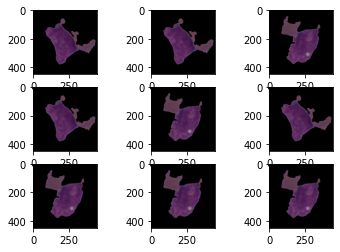

In [3]:
# plot cell photos from the dataset

# define location of dataset
folder = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0/all/'
# plot first few images

for i in range(9):
 # define subplot
 pyplot.subplot(330 + 1 + i)
 # define filename
 filename = folder + 'UID_11_' + str(np.random.randint(low=11, high=12, size = 1)[0])+ '_'+ \
            str(np.random.randint(low=1, high=3, size = 1)[0]) +'_all'  +'.bmp'
 # load image pixels
 image = imread(filename)
 # plot raw pixel data
 pyplot.imshow(image)
# show the figure
pyplot.show()

Loading all images at once, reshaping them , and saving them all in a numpy array would require a lot of memory so, instead we reshape them and put in seperate directories, and we will use the data flow directly from the directories.

We will collect the validation data and training data from folder 0, 1 and 3 into categories for cancer cells and normal cells , then we keep 25% of it in testing folder and rest in training folder 

In [4]:
# create directories
dataset_home = 'dataset_leukemia/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
 # create label subdirectories
 labeldirs = ['abnormal/', 'normal/']
 for labldir in labeldirs:
      newdir = dataset_home + subdir + labldir
      makedirs(newdir, exist_ok=True)

In [5]:

# seed random number generator
random.seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25

#Reading from training folder
folders_list = ['fold_0', 'fold_1', 'fold_2']
folder_category = ['all', 'hem']
for f in folders_list:
    for c in folder_category:
        # copy testing dataset images into subdirectories
        src_directory_train = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/' + f + '/'+c
        for file in listdir(src_directory_train):
          src = src_directory_train + '/' + file
          dst_dir = '/kaggle/working/dataset_leukemia/train/'
          dst = ''
          if random.random() < val_ratio:
             dst_dir = '/kaggle/working/dataset_leukemia/test/'
                
          if c == 'all':
             dst = dst_dir + 'abnormal/'  + file
             copyfile(src, dst)
          else:
             dst = dst_dir + 'normal/'  + file
             copyfile(src, dst)


In [6]:
#Reading validation csv for labels

val_df = pd.read_csv('/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')
val_df.head()


,Patient_ID,new_names,labels
0,UID_57_29_1_all.bmp,1.bmp,1
1,UID_57_22_2_all.bmp,2.bmp,1
2,UID_57_31_3_all.bmp,3.bmp,1
3,UID_H49_35_1_hem.bmp,4.bmp,0
4,UID_58_6_13_all.bmp,5.bmp,1


In [7]:
val_abnormal = val_df['new_names'][val_df['labels'] == 1]
val_normal = val_df['new_names'][val_df['labels'] == 0]

val_abnormal_arr= val_abnormal.to_numpy()
val_normal_arr= val_normal.to_numpy()

In [8]:
val_abnormal_arr

array(['1.bmp', '2.bmp', '3.bmp', ..., '1864.bmp', '1866.bmp', '1867.bmp'],
      dtype=object)

In [9]:
#Reading from validation folder
# seed random number generator
random.seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25

# copy testing dataset images into subdirectories
src_directory_val = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/'
for file in listdir(src_directory_val):
          src = src_directory_val + '/' + file
          dst_dir = '/kaggle/working/dataset_leukemia/train/'
          dst = ''
          if random.random() < val_ratio:
                dst_dir = '/kaggle/working/dataset_leukemia/test/'
            
          if file in val_abnormal_arr:
                dst = dst_dir + 'abnormal/'  + file
                copyfile(src, dst)
          else:
                dst = dst_dir + 'normal/'  + file
                copyfile(src, dst)




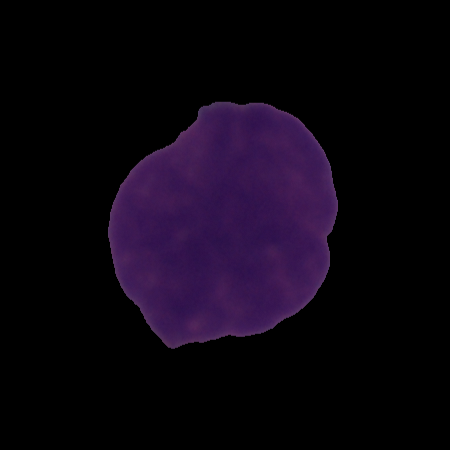
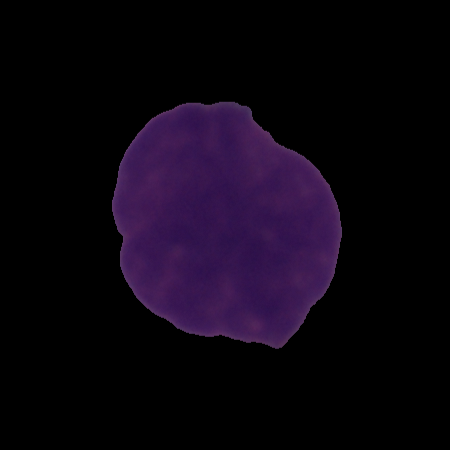
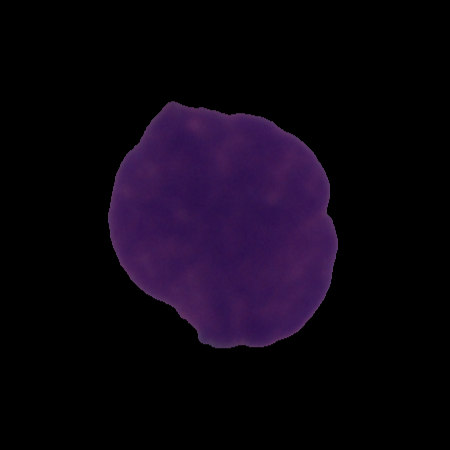


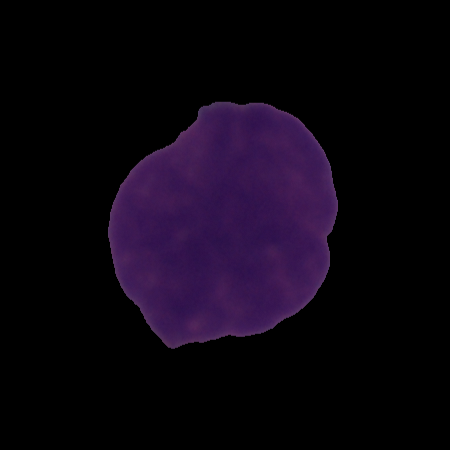
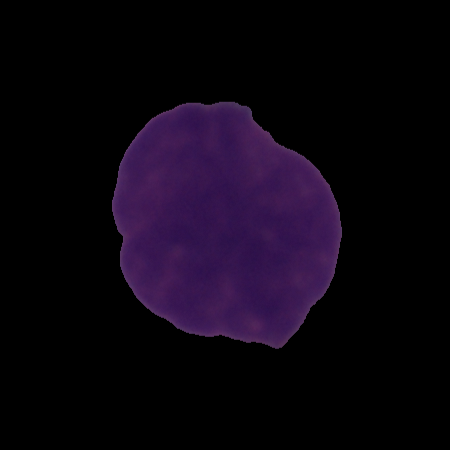
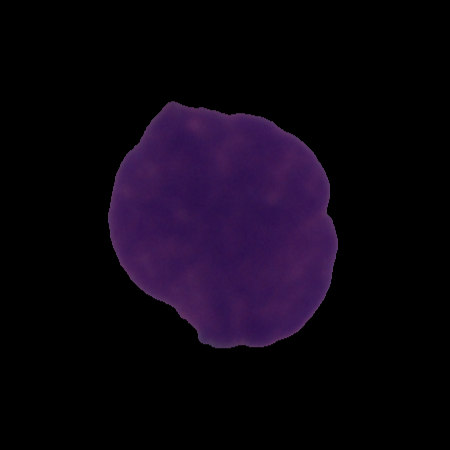


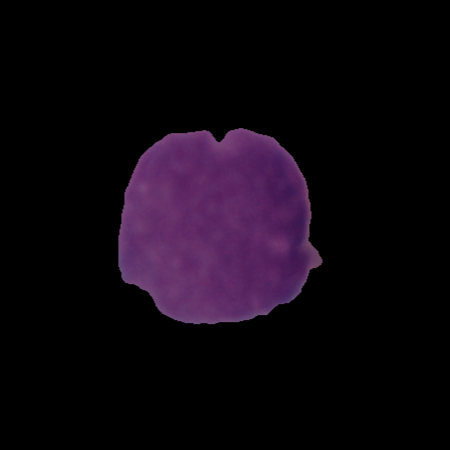
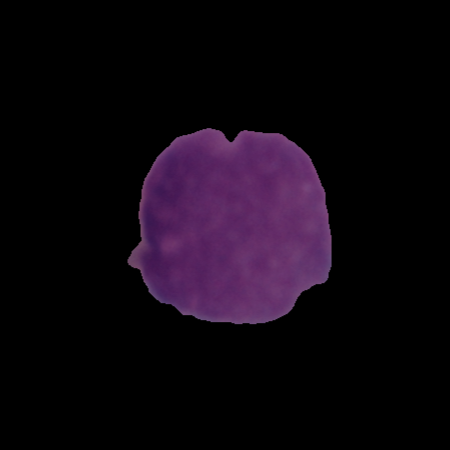
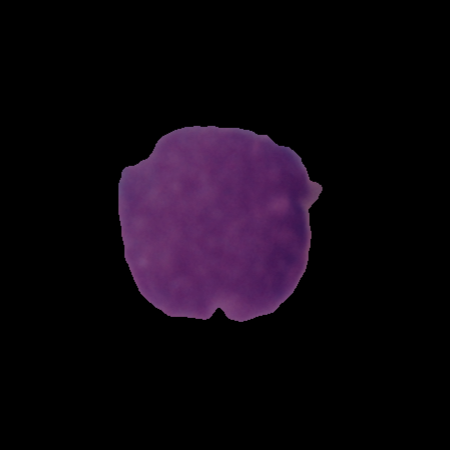


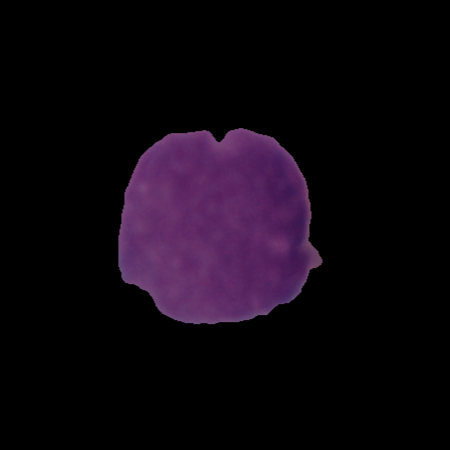
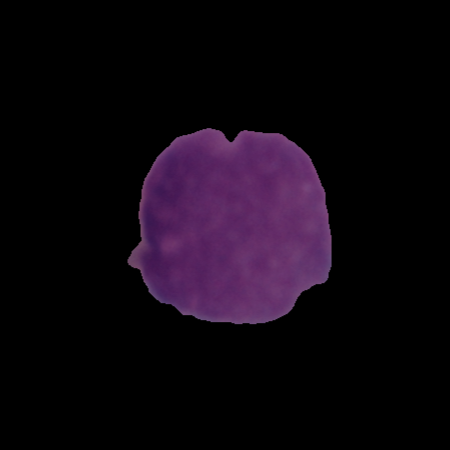
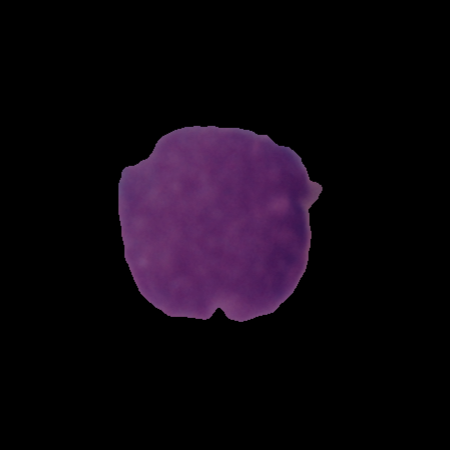


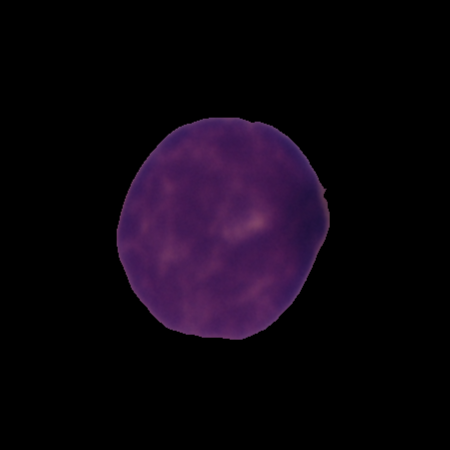
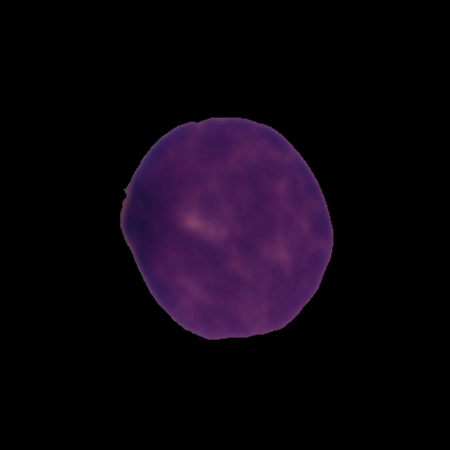
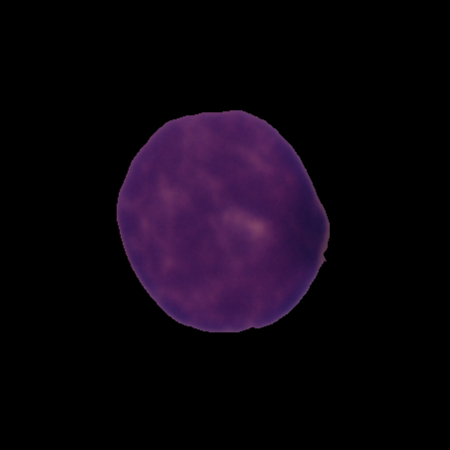


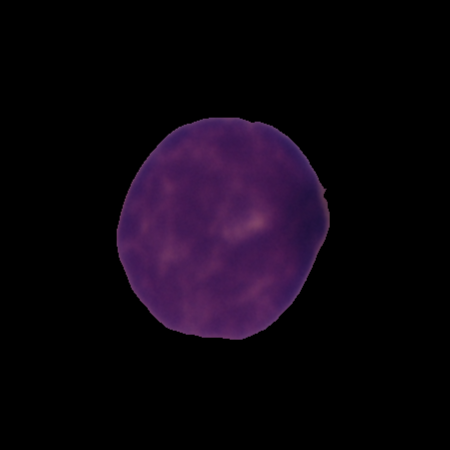
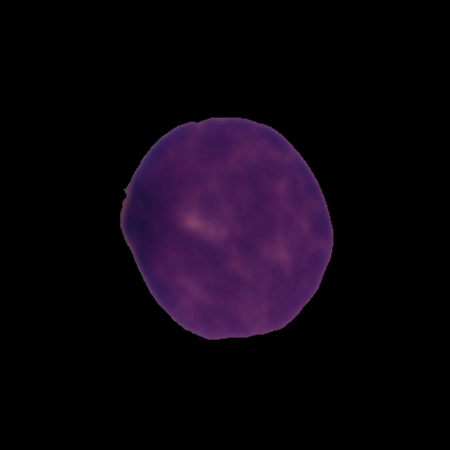
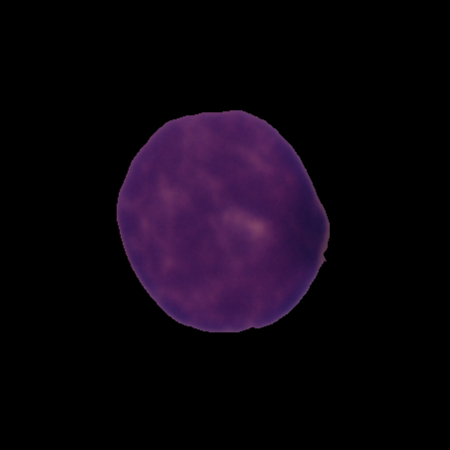

In [10]:
import cv2
import ipyplot
from os import path

# seed random number generator
random.seed(0.01)
# define ratio of pictures to use for horizontal flipping
val_ratio = 0.001
directories = ['abnormal', 'normal']
src_directory_train = '/kaggle/working/dataset_leukemia/train/'


for dir in directories:
    src_directory = src_directory_train + dir + '/'
    for file in listdir(src_directory):
        if random.random() < val_ratio:
            
            path  = src_directory + file
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            horizontal_flip = img[:, ::-1, :]
            vertical_flip = img[::-1, :, :]

            ipyplot.plot_images([img, horizontal_flip, vertical_flip], max_images=3, img_width=200)
        
            src_new_1 = path + '_flipped_1.bmp'
            cv2.imwrite(src_new_1 , horizontal_flip)
            src_new_2 = path + '_flipped_2.bmp'
            cv2.imwrite(src_new_2 , vertical_flip)
            

In [12]:
# define cnn model
def define_model():
 model = Sequential()
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
 model.add(MaxPooling2D((2, 2)))
 model.add(Flatten())
 model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
 model.add(Dense(1, activation='sigmoid'))
 # compile model
 opt = SGD(lr=0.001, momentum=0.9)
 model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
 return model


In [11]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
 # plot loss
 pyplot.subplot(211)
 pyplot.title('Cross Entropy Loss')
 pyplot.plot(history.history['loss'], color='blue', label='train')
 pyplot.plot(history.history['val_loss'], color='orange', label='test')
 # plot accuracy
 pyplot.subplot(212)
 pyplot.title('Classification Accuracy')
 pyplot.plot(history.history['accuracy'], color='blue', label='train')
 pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
 # save plot to file
 filename = sys.argv[0].split('/')[-1]
 pyplot.savefig(filename + '_plot.png')
 pyplot.close()

In [35]:
def inception_model():
    input_img = Input(shape=(200, 200, 3))

    ### 1st layer
    layer_1 = Conv2D(5, (1,1),  padding='same', activation='relu')(input_img)
    layer_1 = Conv2D(5, (3,3), padding='same', activation='relu')(layer_1)

    ##
    layer_2 = Conv2D(5, (1,1), padding='same', activation='relu')(input_img)
    layer_2 = Conv2D(5, (5,5), kernel_initializer='he_uniform', padding='same', activation='relu')(layer_2)

    layer_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
    layer_3 = Conv2D(5, (1,1), kernel_initializer='he_uniform', padding='same', activation='relu')(layer_3)

    mid_1 = tensorflow.keras.layers.concatenate([layer_1, layer_2, layer_3], axis = 3)

    flat_1 = Flatten()(mid_1)

    dense_1 = Dense(1200,kernel_initializer='he_uniform',  activation='relu')(flat_1)
    dense_2 = Dense(600, kernel_initializer='he_uniform', activation='relu')(dense_1)
    dense_3 = Dense(150, kernel_initializer='he_uniform', activation='relu')(dense_2)
    output = Dense(1, activation='sigmoid')(dense_3)

    model = models.Model(inputs=input_img, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [31]:
# run the test harness for evaluating a model
def run_test_harness():
 # define model
 model = inception_model()
 # create data generator
 datagen = ImageDataGenerator(rescale=1.0/255.0)
 # prepare iterators
 train_it = datagen.flow_from_directory('/kaggle/working/dataset_leukemia/train/',
 class_mode='binary', batch_size=64, target_size=(200, 200))
 test_it = datagen.flow_from_directory('/kaggle/working/dataset_leukemia/test/',
 class_mode='binary', batch_size=64, target_size=(200, 200))
 # fit model
 history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
 validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
 # evaluate model
 _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
 print('> %.3f' % (acc * 100.0))
 # learning curves
 summarize_diagnostics(history)

In [34]:
 
# entry point, run the test harness
run_test_harness()

Found 9354 images belonging to 2 classes.
Found 3180 images belonging to 2 classes.


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-12-28 15:43:58.719912: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


> 82.138
